0.0316	0.34749317	PFL_l20.0_M20,20_K50_R50,1_LR_a9a_exdirb1,100.0_sgd0.0316_b128_seed0.csv
0.00316	0.33280958	SFL_l20.0_M20,20_K50_R50,1_LR_a9a_exdirb1,100.0_sgd0.00316_b128_seed0.csv
1.0	0.32374141	PFL_l20.0_M20,20_K50_R50,1_LR_a9a_exdirb2,100.0_sgd1.0_b128_seed0.csv
0.01	0.32550264	SFL_l20.0_M20,20_K50_R50,1_LR_a9a_exdirb2,100.0_sgd0.01_b128_seed0.csv
1.0	0.16094664	PFL_l20.0_M20,20_K50_R50,1_LR_w8a_exdirb1,100.0_sgd1.0_b128_seed0.csv
0.316	0.12426898	SFL_l20.0_M20,20_K50_R50,1_LR_w8a_exdirb1,100.0_sgd0.316_b128_seed0.csv
10.0	0.12193578	PFL_l20.0_M20,20_K50_R50,1_LR_w8a_exdirb2,100.0_sgd10.0_b128_seed0.csv
3.16	0.11574320	SFL_l20.0_M20,20_K50_R50,1_LR_w8a_exdirb2,100.0_sgd3.16_b128_seed0.csv
0.0316	0.34794099	PFL_l20.0001_M20,20_K50_R50,1_LR_a9a_exdirb1,100.0_sgd0.0316_b128_seed0.csv
0.00316	0.33350392	SFL_l20.0001_M20,20_K50_R50,1_LR_a9a_exdirb1,100.0_sgd0.00316_b128_seed0.csv
1.0	0.32499732	PFL_l20.0001_M20,20_K50_R50,1_LR_a9a_exdirb2,100.0_sgd1.0_b128_seed0.csv
0.01	0.32648295	SF

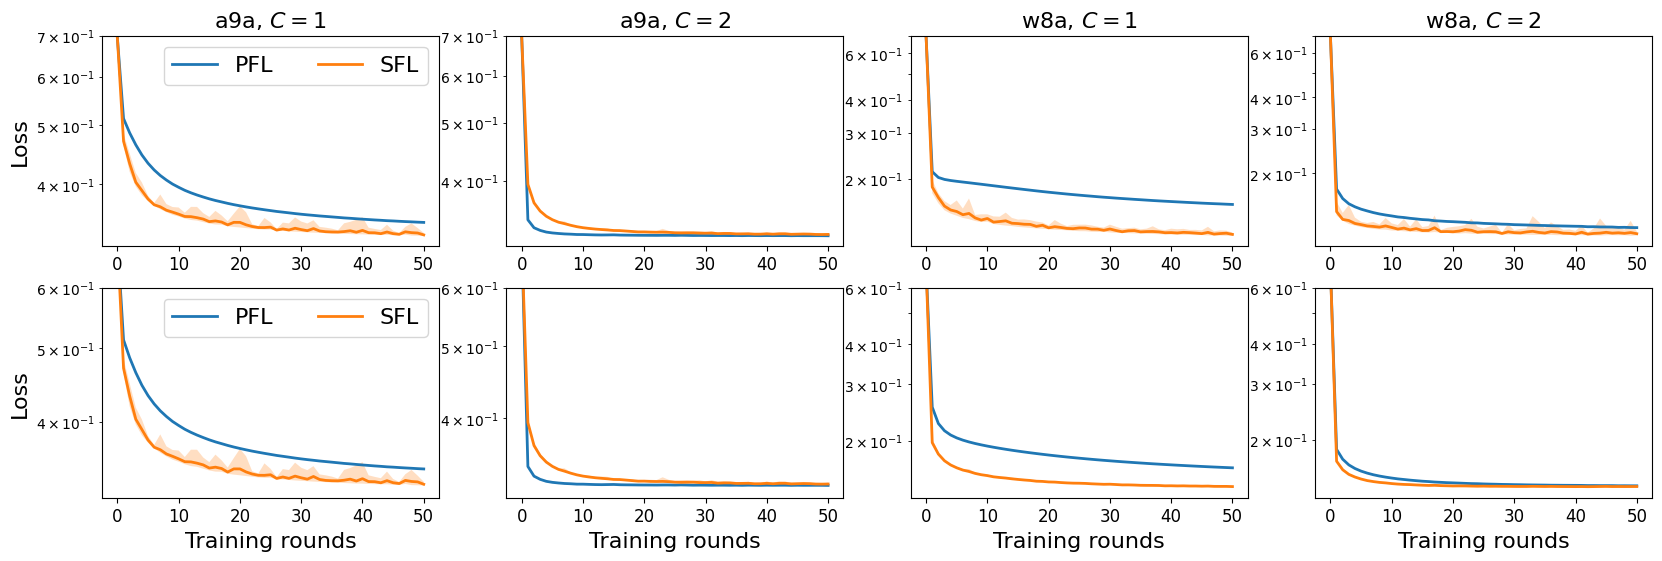

In [33]:
import sys 
sys.path.append("/home/moon/data/exps/SFL/")

import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from types import SimpleNamespace

from sim.utils.record_utils import read_fromcsv
from plots.plot_utils import save_fig_timestamp


def linear_search(setup, pattern, lrs, K, subpath=''):
    global path, seeds, args
    
    select = setup['select']

    for i in range(len(lrs)):
        # stack the distances over seeds
        for j in range(len(seeds)):
            source_file = pattern.format(K, lrs[i], seeds[j])
            df = read_fromcsv(source_file, os.path.join(path, subpath))
            data = df.iloc[:, 1].values
            if j == 0:
                distances = np.array(data)
            else:
                distances = np.vstack((distances, data))
        # compare the averaged distances over multiple seeds and last `select` rounds
        if i == 0:
            distance_avg_seeds = distances.mean(axis=0)
            distance_avg_seeds_rounds = distance_avg_seeds[-select:].mean(axis=0)
            best_avg_distance = distance_avg_seeds_rounds
            best_lr = lrs[i]
        else:
            distance_avg_seeds = distances.mean(axis=0)
            distance_avg_seeds_rounds = distance_avg_seeds[-select:].mean(axis=0)
            if distance_avg_seeds_rounds <= best_avg_distance:
                best_avg_distance = distance_avg_seeds_rounds
                best_lr = lrs[i]
    print('{}\t{:.8f}\t{}'.format(best_lr, best_avg_distance, pattern.format(K, best_lr, seeds[0])))
    return best_lr
    
def plotmean(ax, patterns, setup):
    global args, seeds, lrs
    e = setup['end']+1
    y = setup['y']
    Ks = [args.K]

    ylabel = 'Loss'
    xlabel = 'Training rounds'
    #filename = f"quadratic_F1_{args['F1'][0]},{args['F1'][1]}_F2_{args['F2'][0]},{args['F2'][1]}_M{args['M']}_R{args['R']}"
    
    PFLdata, PFLlegend = [], []
    for k_id in range(len(Ks)):
        best_lr = linear_search(setup, patterns[0], lrs, Ks[k_id])
        for seed_id in range(len(seeds)):
            file = patterns[0].format(Ks[k_id], best_lr, seeds[seed_id])
            df = read_fromcsv(file, path)
            datat = df.iloc[:e, y].values
            if seed_id == 0:
                data = datat
            else:
                data = np.vstack((data, datat))
        PFLdata.append(data)
        #PFLlegend.append('PFL, $K$={}'.format(Ks[k_id]))
        PFLlegend.append('PFL')

    SFLdata, SFLlegend = [], []
    for k_id in range(len(Ks)):
        best_lr = linear_search(setup, patterns[1], lrs, Ks[k_id])
        for seed_id in range(len(seeds)):
            file = patterns[1].format(Ks[k_id], best_lr, seeds[seed_id])
            df = read_fromcsv(file, path)
            datat = df.iloc[:e, y].values
            if seed_id == 0:
                data = datat
            else:
                data = np.vstack((data, datat))
        SFLdata.append(data)
        #SFLlegend.append('SFL, $K$={}'.format(Ks[k_id]))
        SFLlegend.append('SFL')
    
    #fig = plt.figure(figsize=(5.4, 4)) # 5,4
    x_axis = list(range(0, e))
    colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
    for i in range(len(Ks)):
        ax.plot(x_axis, PFLdata[i].mean(axis=0), linestyle='solid', color=colors[0], lw=2, label=PFLlegend[i])
        #plt.fill_between(x_axis, FedAvgdata[i].mean(axis=0) - FedAvgdata[i].std(axis=0), FedAvgdata[i].mean(axis=0) +FedAvgdata[i].std(axis=0), facecolor=colors[i], alpha=0.25) 
        ax.fill_between(x_axis, PFLdata[i].min(axis=0), PFLdata[i].max(axis=0), facecolor=colors[0], alpha=0.25, label=None) 

    for i in range(len(Ks)):
        ax.plot(x_axis, SFLdata[i].mean(axis=0), linestyle='solid', color=colors[1], lw=2, label=SFLlegend[i])
        #plt.fill_between(x_axis, SSLdata[i].mean(axis=0) - SSLdata[i].std(axis=0), SSLdata[i].mean(axis=0) + SSLdata[i].std(axis=0), facecolor=colors[i], alpha=0.25) 
        ax.fill_between(x_axis, SFLdata[i].min(axis=0), SFLdata[i].max(axis=0), facecolor=colors[1], alpha=0.25, label=None) 

    #plt.title(plotname, fontsize=20)        
    #ax.set_ylabel(ylabel, fontsize=16)
    #ax.set_xlabel(xlabel, fontsize=16)
    #plt.ylim(ymin=0, ymax=2.5)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    #ax.set_yticks(fontsize=12)
    ax.set_yscale('log')
    #plt.xlim(xmin=-1, xmax=10) # for indentical data
    #plt.xlim(xmin=0, xmax=args.R) # for general heterogeneous data
    #plt.ylim(ymin=0.0001, ymax=10)
    #plt.ylim(ymin=0.1, ymax=10)
    #plt.legend([line1, line2, line3], lines, loc=None, ncol= 1, prop={'size': 14}) # loc = 1 or 4
    #if args['F1'][1] == '100.00':
    #ax.legend(loc=1, ncol= 2, prop={'size': 18}) # apx
    #plt.legend(loc=1, ncol= 1, prop={'size': 18}) # main body
    #plt.minorticks_on()
    #plt.grid(which='minor', ls=':', axis='both', alpha=0.6)
    #print(filename)
    #plt.savefig('../figs/{}.png'.format(filename), bbox_inches='tight', dpi=300)


def main():
    global path, lrs, seeds, args
    path = f"/home/moon/data/exps/SFL/save/LR/"
    seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    #seeds = [0, 1, 2, 3, 4]
    #lrs = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
    lrs = [0.001, 0.00316, 0.01, 0.0316, 0.1, 0.316, 1.0, 3.16, 10.0, 31.6, 100.0]
    
    args = { "l2": "0.0", "M": 20, "P": 20, "K": 50, "R": 50, "d": "w8a", "b": 128}
    #args = { "l2": "0.0", "M": 1000, "P": 10, "K": 50, "R": 50, "d": "w8a", "b": 8}
    args['eval_every'] = 1
    args = SimpleNamespace(**args)

    fig, axs = plt.subplots(2, 4, figsize=(20, 6))
    for i in range(2):
        for j in range(4):
            title = ''
            if i in [0]:
                args.l2 = 0.0
            elif i in [1]:
                args.l2 = 0.0001

            if j in [0,1]:
                args.d = 'a9a'
                title = title + args.d
            elif j in [2,3]:
                args.d = 'w8a'
                title = title + args.d
            
            if j in [1,3]:
                partition = "exdirb2,100.0"
                title = title + ', $C=2$'
            elif j in [0,2]:
                partition = 'exdirb1,100.0'
                title = title + ', $C=1$'
                
            pattern1 = f"PFL_l2{args.l2}_M{args.M},{args.P}_K{{}}_R{args.R},{args.eval_every}_LR_{args.d}_{partition}_sgd{{}}_b{args.b}_seed{{}}.csv"    
            pattern2 = f"SFL_l2{args.l2}_M{args.M},{args.P}_K{{}}_R{args.R},{args.eval_every}_LR_{args.d}_{partition}_sgd{{}}_b{args.b}_seed{{}}.csv"
            plotmean(axs[i,j], patterns = [pattern1, pattern2], setup={'start': 1, 'end': 50, 'y': 1, 'step': 1, 'compute': 0, 'select': 5})
            if j == 0:
                axs[i,j].set_ylabel('Loss', fontsize=16)
                axs[i,j].legend(loc=1, ncol= 2, prop={'size': 16})
            if i == 1:
                axs[i,j].set_xlabel('Training rounds', fontsize=16)
            
            if i in [0]:
                axs[i,j].set_title(title, fontsize=16)
                axs[i,j].set_ylim(ymax=0.7, ymin=None)
            elif i in [1]:
                axs[i,j].set_ylim(ymax=0.6, ymin=None)
    #linear_search(pattern1, K=2)
    #linear_search(pattern2, K=2)
    #save_fig_timestamp(fig, format='.png', path='../figs/')
    #filename = f"M{args.M},{args.P}_K{args.K}_R{args.R},{args.eval_every}_LR_{args.d}_{partition}_sgd{{}}_b{args.b}".
    filename = f"LR_M{args.M}_K{args.K}"
    fig.savefig('../figs/{}.pdf'.format(filename), bbox_inches='tight', dpi=300)
    

    

if __name__ == '__main__':
    main()
